In this notebook the aim is to classify spectra for stars. Spectra are very detailed colors. Instead of 3 colors like in RGB they can have much more. In our case they are 3072 in the data. Like digital images they have numeric values. Here they are floats; for each example the features are a vector of 3072 floats.

Usually spectra are classified by looking per eye on diagrams which show the feature value as function of the feature 'color'. Instead of 'color' the feature number can be used without loosing information.  Here we aim to replace that time consuming method by an supervised learning method.

In [2]:
#basic libraries
import numpy as np
import pandas as pd
import scipy as sp

#plotting libraries
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#logistic regression is used 
from sklearn.linear_model import LogisticRegression

Below we load the feature and label data.

In [3]:
#directory of the data
path='/home/tobias/ml-testing/spectra-ML/met-cal-22/'
#feature data
x=np.loadtxt(path+'feature_classification.txt')
print(f"shape of feature data is {np.shape(x)}")
print(f"There are {np.shape(x)[1]} examples with each {np.shape(x)[0]} features")
#includes besides main labels also other data
yplus=np.loadtxt(path+'label_classification.txt')
print(f"shape of label data is {np.shape(yplus)}")
#there are three labels values
print(f"number of 0 labels: {np.count_nonzero(yplus[0,:]==0)}")
print(f"number of 1 labels: {np.count_nonzero(yplus[0,:]==1)}")
print(f"number of 2 labels: {np.count_nonzero(yplus[0,:]==2)}")

shape of feature data is (3072, 3773)
There are 3773 examples with each 3072 features
shape of label data is (5, 3773)
number of 0 labels: 57
number of 1 labels: 3661
number of 2 labels: 55


There are three exclusive labels. 1 and 2 describe different recognisable classes. 0 is the label for all examples for which the class cannot be identified.

 We now look on the features to exclude some of them. For that we calculate basic statistic for the full data and for each class separately. 

In [4]:
#separating the classes for calculating statistics
class0=x[:,np.where(yplus[0,:]==0)]
class1=x[:,np.where(yplus[0,:]==1)]
class2=x[:,np.where(yplus[0,:]==2)]
print(f"shape of class 0 features is {np.shape(class0)}")
res=np.zeros((15,3072))
cg=np.shape(x)[1] #number  of examples
for i in range(3072):
    res[0,i]=i
    res[1,i]= np.count_nonzero(x[i]==0)/cg #fraction of zeros (means NaN)  for features
    res[2,i]=1.92499995231628+i*0.000187174489838071  #wavelength in micron the physical meaning of the features
    res[3,i]=np.mean(x[i]) #statistic for all
    res[4,i]=np.median(x[i])    
    res[5,i]=np.std(x[i])  #statistic for all
    res[6,i]=np.mean(class0[i]) #statistic for class0
    res[7,i]=np.median(class0[i])    
    res[8,i]=np.std(class0[i])    
    res[9,i]=np.mean(class1[i]) #statistic for class1
    res[10,i]=np.median(class1[i])    
    res[11,i]=np.std(class1[i])
    res[12,i]=np.mean(class2[i]) #statistic of class2
    res[13,i]=np.median(class2[i])    
    res[14,i]=np.std(class2[i])  

shape of class 0 features is (3072, 1, 57)


We now plot the mean of all examples. 

Text(0, 0.5, 'feature value')

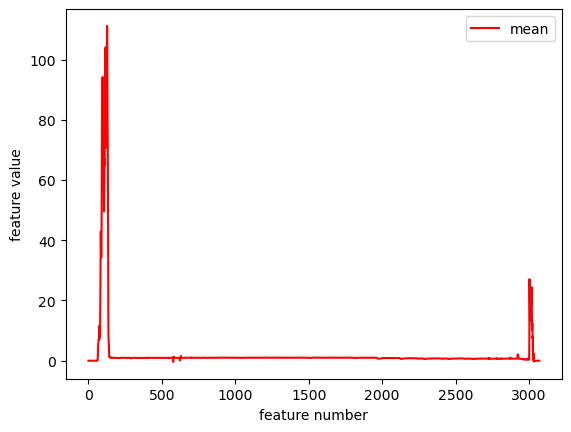

In [5]:
   
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.legend(loc="best")
#plt.xlim(1.95,2.48)
#plt.ylim(0.3,1.4)
plt.xlabel("feature number")
plt.ylabel("feature value")

Some of most extreme values are much larger than most. We zoom in to be able to see the details in between. 

Text(0, 0.5, 'feature value')

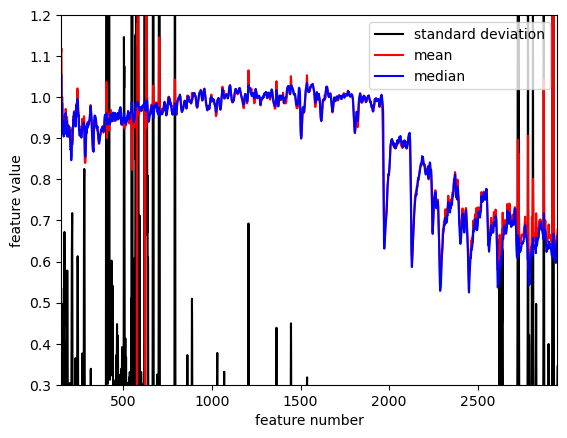

In [48]:
plt.plot(res[0],res[5],'-',color='black',label='standard deviation') 
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.plot(res[0],res[4],'-',color='blue',label='median') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.3,1.2)
plt.xlabel("feature number")
plt.ylabel("feature value")

It is visisble that in the mean many feature are about 1. That is because of previous feature scaling and is useful to make the different examples more similar and thus makes it possible to use simpler methods as otherwise possible. The scaling method just calculated the median in bins and fit a line to it. It used features between 800 and 1900 because below the data is more problematic and above 1900 a line is not a good model of the data. 

At some features smaller than about 800 and for features larger than about 2700 the standard deviation ('variation between different examples') is as large or larger than the typical value there.

To avoid these more difficult ranges we restrict the feature range by selecting the feature between 800 and 2700 for further analysis. 

In [11]:
#lower and upper border
low=800
high=2700
#features selection
xsel=x[low:high]
#statistic selection
ressel=res[:,low:high] 
print(f"state of statistic in selected range {np.shape(ressel)}")
#adding a new feature index which starts at 0 
resselb=np.zeros((16,1900))
resselb[0:15,:]=ressel
resselb[15,:]=np.arange(0,1900,1)
# some visuazition would be good best by class heatmap does not work too slow 
#sns.heatmap(xsel, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('features'),plt.xlabel('feature number'),plt.ylabel('example number');

state of statistic in selected range (15, 1900)


We look now on the classes in the selected range. 

Text(0, 0.5, 'average feature value')

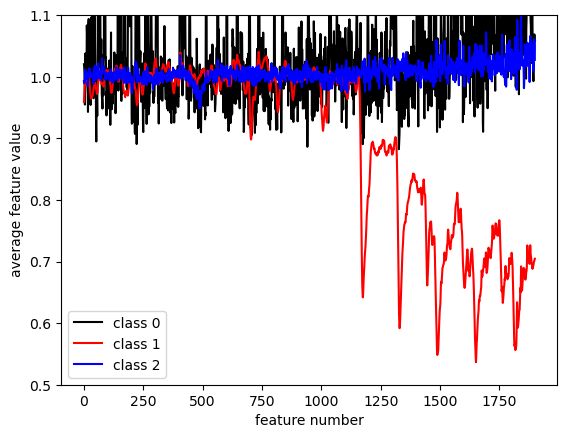

In [12]:
plt.plot(resselb[15],ressel[6],'-',color='black',label='class 0') 
plt.plot(resselb[15],ressel[9],'-',color='red',label='class 1') 
plt.plot(resselb[15],ressel[12],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average feature value")

There are clear differences in the mean feature value between class 1 and class 2. It is less clear for class 0. THat is expected because it is the class of the left over cases. 

We use a relative large test set is used because not many sources are in the rare classes 0 and 2.

In [15]:
#Yplus[0] is the true label the other columns indicate additional information of the examples
xsel_train, xsel_test, y_train, y_test, yplus_train,yplus_test= train_test_split(np.transpose(xsel), yplus[0], yplus.T, test_size=0.3, random_state=42)
print(f"shape of training features {np.shape(xsel_train)}")
print(f"shape of training labels {np.shape(y_train)}")

shape of training features (2641, 1900)
shape of training labels (2641,)


We use logistic regression since it is relative simple and it can be easier interpreted. 

In [16]:
#We fit it to the training data
lr1 = LogisticRegression('none',max_iter=200)
lr1.fit(xsel_train,y_train)

LogisticRegression(max_iter=200, penalty='none')

We are now making prediction for the test and training set. 

In [17]:
#Here probabilities are calculated for each class.
restr=lr1.predict_proba(xsel_train)  
#Here is the most likely class is the prediction
restrc=lr1.predict(xsel_train)  
restec=lr1.predict(xsel_test)


We are now calculating the confusion matrix and display them. 

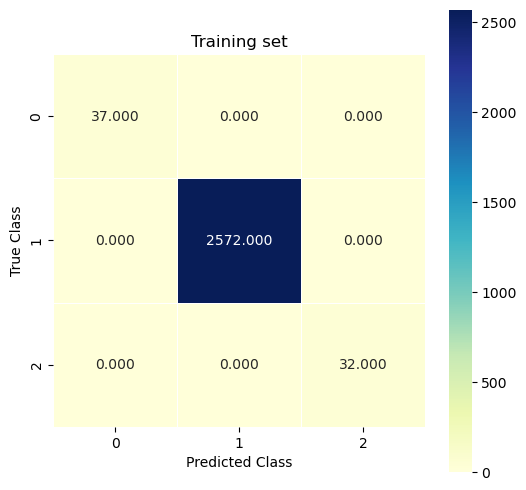

In [19]:
cm_nbtrain = confusion_matrix(y_train, restrc)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Class'),plt.ylabel('True Class');

As visisble in the confusion matrix, the model predicts the labels perfectly for the training label. We are now looking on the test set, see below. 

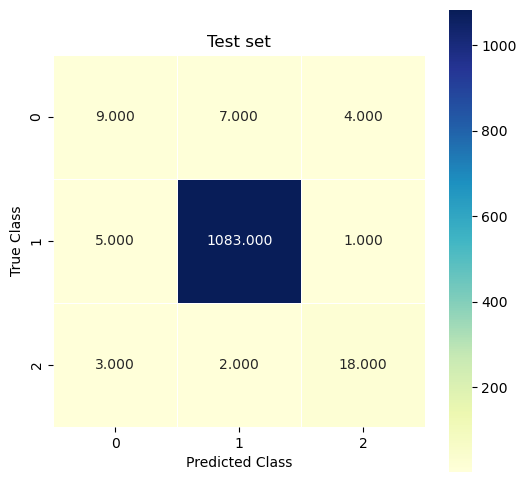

In [20]:
cm_nbtest = confusion_matrix(y_test, restec)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Class'),plt.ylabel('True Class');

In it there are a number of missclassified sources. That means that there is overfitting. This means the 
algorithm separates the classes partly by using feature which are only by chance useful but are not useful in general. 

To be quantitative in deciding how good the model is we use the F1 measure of each class. We use the F1 measure because our classes are imbalanced and the rare classes are more interesting than the common class.  We use the classes separately because as expected the rare classes are more difficult. 

In [23]:
#we are defining afunction 
#gets f1 score for a specified class from the confusion matrix 
def fmeas(conf_matrix,x):
    if np.sum(conf_matrix[:,x])==0:
        prec=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
    if np.sum(conf_matrix[x])==0:
        rec=0
    else:
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])

    if prec==0 and rec==0: #f1 score in special case
        f1=0
    else: #f1 score on standard case
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])
        f1=(2*prec*rec)/(prec+rec)
    return f1

In [24]:
print(f"F1 score (test, class 0) {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 1) {round(fmeas(cm_nbtest,1),3)}")
print(f"F1 score (test, class 2) {round(fmeas(cm_nbtest,2),3)}")

F1 score (test, class 0) 0.486
F1 score (test, class 1) 0.993
F1 score (test, class 2) 0.783


The F1 is worse for class 2 and even worse for class 0. That class 0 is most difficult is to be expected, because it is a left over class.

To reduce overfitting, regularization is now added. A large range of regularizations values is explored.


In [26]:
#rtesting different regularization in steps of about a factor 2
regs=np.zeros((7,16))
regs[0,0]=10
regs[0,1]=5
regs[0,2]=2.2
regs[0,3]=1
regs[0,4]=0.5
regs[0,5]=0.22
regs[0,6]=0.1
regs[0,7]=0.05
regs[0,8]=0.022
regs[0,9]=0.01
regs[0,10]=0.005
regs[0,11]=0.0022
regs[0,12]=0.001
regs[0,13]=0.0005
regs[0,14]=0.00022
regs[0,15]=0.0001
for i in range(np.shape(regs)[1]):
    print(f"regulurization {regs[0,i]}")
    #fitting
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs[0,i])
    lr3.fit(xsel_train,y_train)
    #predicting
    restrc3=lr3.predict(xsel_train)  
    restec3=lr3.predict(xsel_test)
    #confusion matrix
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    #f1 score calucluation of the two rares classes and their mean
    regs[1,i]=fmeas(cm_nbtest3,0)
    regs[2,i]=fmeas(cm_nbtest3,2)
    regs[3,i]=np.mean(regs[1:3,i])
    regs[4,i]=fmeas(cm_nbtrain3,0)
    regs[5,i]=fmeas(cm_nbtrain3,2)
    regs[6,i]=np.mean(regs[4:6,i])  

regulurization 10.0
regulurization 5.0
regulurization 2.2
regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


F1 score (test, class 0) no regulurization 0.486
F1 score (test, class 2) no regulurization 0.783
F1 score (test, class 0) best regulurization 0.519
F1 score (test, class 2) best regulurization 0.836


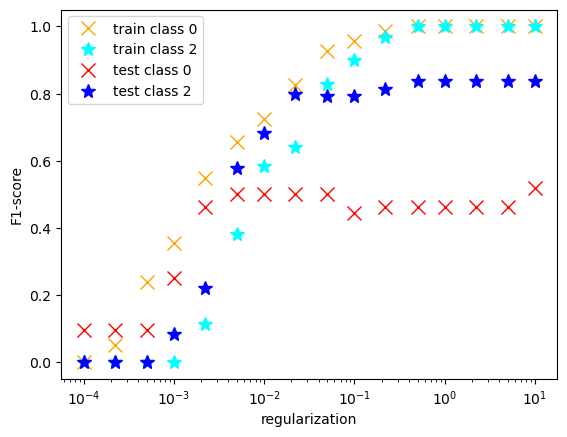

In [27]:
plt.plot(regs[0],regs[4],'x',color='orange',ms=10,label='train class 0') 
plt.plot(regs[0],regs[5],'*',color='cyan',ms=10,label='train class 2') 
plt.plot(regs[0],regs[1],'x',color='red',ms=10,label='test class 0') 
plt.plot(regs[0],regs[2],'*',color='blue',ms=10,label='test class 2') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
print(f"F1 score (test, class 0) no regulurization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regulurization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regulurization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regulurization {round(max(regs[2]),3)}")

Regularization improves only a little for test, the best F1 score with regularization is very similar to the F1 score with no regularization. It are a regularization values which perform better for train than for test. Thus, it is is principle overfitting, but when the performance for test and train are similar, the performance for test is not optimal, especially for class 0. Thus, some overfitting is the better option here.



Intrinsic noisy (random variations. Since in our data neighboring features sample similar true values, they should be similar, noise is the main reason for differences.) clearly affects the data. It is a main reason for class 0. Logistic regression cannot recogize that from the features because of the random effects of noise and the independence of features in logistic regression. The measure of the instrinsic noisyness is the signal to noise. The signal to noise can be estimated as standard deviation of difference between the features and the features smoothed with a Gaussian of a width of 1 pixel.



Below the standard deviation of the different classes is ploted. It is visible, that calss 1 and 2 have similar standard deviations at most features, while the standard deviation of class 0 is clearly larger. That is slightly different than the noise measure above, but it shows that noise is different bewteen the calsses and thus including it should improve performance. 

Text(0, 0.5, 'standard deviation')

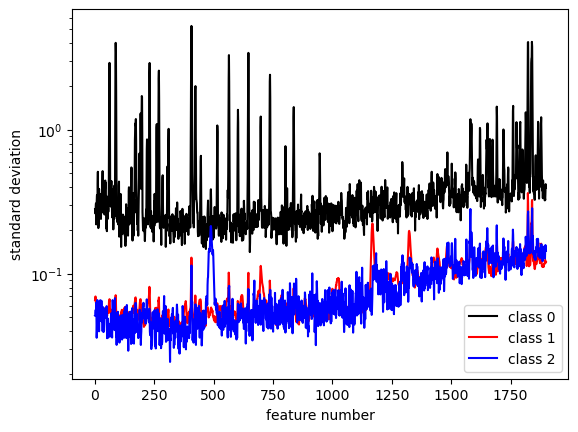

In [28]:
plt.plot(resselb[15],resselb[8],'-',color='black',label='class 0') 
plt.plot(resselb[15],resselb[11],'-',color='red',label='class 1') 
plt.plot(resselb[15],resselb[14],'-',color='blue',label='class 2') 
plt.legend(loc="best")
#plt.ylim(0,1.1)
plt.yscale("log")
plt.xlabel("feature number")
plt.ylabel("standard deviation")

In [32]:
#the signal to noise is in the feature column 5
print(f"signal to noise is {yplus[4]}")

signal to noise is [ 54.56041175  58.37582071  49.42498075 ...  51.15859649  93.74415085
 146.37331923]


We the inverse of the signal to noise, the noise level as additional feature, to make it more important when the signal is low. This feature is scaled on the same level as the other features, by scaling the mean in the training samples to one. 

In [34]:

print(f"current feature shape of traing set is {np.shape(xsel_train)}")
#create new array with one feature more
xsel_train2=np.zeros((np.shape(xsel_train)[0],np.shape(xsel_train)[1]+1))
xsel_test2=np.zeros((np.shape(xsel_test)[0],np.shape(xsel_test)[1]+1))
#copy old 
xsel_train2[:,0:np.shape(xsel_train)[1]]=xsel_train
xsel_test2[:,0:np.shape(xsel_test)[1]]=xsel_test
#add noise level as feature it
#scale noise using training set mean
xsel_train2[:,np.shape(xsel_train)[1]]=1/yplus_train[:,4]/np.mean(1/yplus_train[:,4])
xsel_test2[:,np.shape(xsel_test)[1]]=1/yplus_test[:,4]/np.mean(1/yplus_train[:,4])
print(f"mean of noise feature is {np.mean(xsel_train2[:,np.shape(xsel_train)[1]])}")

current feature shape of traing set is (2641, 1900)
mean of noise feature is 1.0


We repeat now the regularized logistic regression but now with the noise level as additional feature.

In [36]:
#regularzaition parameter in steps of factor 2
regs2=np.zeros((7,16))
regs2[0,0]=10
regs2[0,1]=5
regs2[0,2]=2.2
regs2[0,3]=1
regs2[0,4]=0.5
regs2[0,5]=0.22
regs2[0,6]=0.1
regs2[0,7]=0.05
regs2[0,8]=0.022
regs2[0,9]=0.01
regs2[0,10]=0.005
regs2[0,11]=0.0022
regs2[0,12]=0.001
regs2[0,13]=0.0005
regs2[0,14]=0.00022
regs2[0,15]=0.0001
for i in range(np.shape(regs2)[1]):
    print(f"regulurization {regs2[0,i]}")
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs2[0,i])
    lr3.fit(xsel_train2,y_train)
    restrc3=lr3.predict(xsel_train2)  
    restec3=lr3.predict(xsel_test2)
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    regs2[1,i]=fmeas(cm_nbtest3,0)
    regs2[2,i]=fmeas(cm_nbtest3,2)
    regs2[3,i]=np.mean(regs2[1:3,i])
    regs2[4,i]=fmeas(cm_nbtrain3,0)
    regs2[5,i]=fmeas(cm_nbtrain3,2)
    regs2[6,i]=np.mean(regs2[4:6,i])  

regulurization 10.0
regulurization 5.0
regulurization 2.2
regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


Plotting F1 score with the additional feature. 

Text(0.5, 1.0, 'noise level is additional feature')

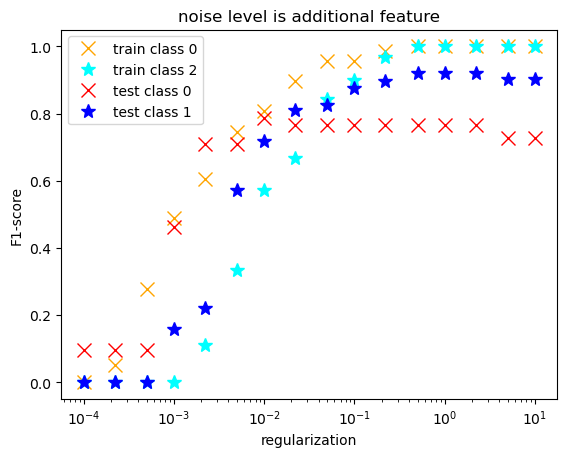

In [37]:
plt.plot(regs2[0],regs2[4],'x',color='orange',ms=10,label='train class 0') 
plt.plot(regs2[0],regs2[5],'*',color='cyan',ms=10,label='train class 2') 
plt.plot(regs2[0],regs2[1],'x',color='red',ms=10,label='test class 0') 
plt.plot(regs2[0],regs2[2],'*',color='blue',ms=10,label='test class 1') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("noise level is additional feature")

Now the comparison of the F1 scores

In [38]:

print(f"F1 score (test, class 0) no regulurization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regulurization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regulurization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regulurization {round(max(regs[2]),3)}")
print(f"F1 score (test, class 0) best regulurization with noise {round(max(regs2[1]),3)}")
print(f"F1 score (test, class 2) best regulurization with noise {round(max(regs2[2]),3)}")

F1 score (test, class 0) no regulurization 0.486
F1 score (test, class 2) no regulurization 0.783
F1 score (test, class 0) best regulurization 0.519
F1 score (test, class 2) best regulurization 0.836
F1 score (test, class 0) best regulurization with noise 0.788
F1 score (test, class 2) best regulurization with noise 0.92


Adding the noise as additional parameter has clearly improved the classification performance. As before there is overfitting with large C since it performs better on the traing set than on the test set but the overfitting does not seem to impact the performance on the test sample much. The clasification of class 0 peaks for  C~0.01 while class 2 improves until about 1 by a larger amount. That behaviour is to be expected, because in the absennce of many common properties of class 0 less features are needed to recognise it as well as possible in the rather small sample. 

We now look closer on the problems in classification. For that we run the logistic regression again with  C of 1 and first plot the confusion matrix.

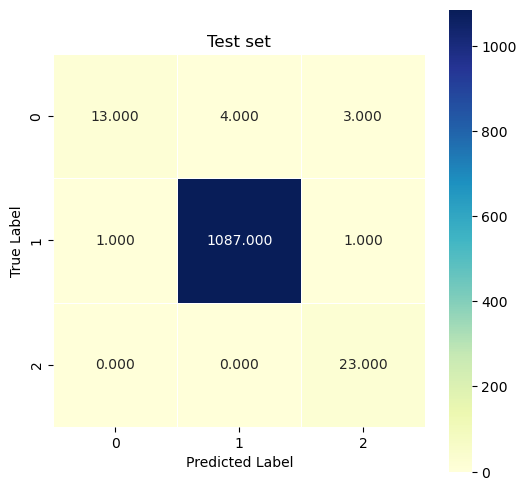

In [39]:
lr3 = LogisticRegression('l2',max_iter=1500,C=1)
lr3.fit(xsel_train2,y_train)
restrc3=lr3.predict(xsel_train2)  
restec3=lr3.predict(xsel_test2)
restrp3=lr3.predict_proba(xsel_train2)  
restep3=lr3.predict_proba(xsel_test2)
cm_nbtest4 = confusion_matrix(y_test, restec3)
cm_nbtrain4 = confusion_matrix(y_train, restrc3)  
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest4, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

As visible in the confusion matrix the main problem is that class 0 cases are classfied as other classes. There are also a few missclasfied class 1 cases but a much smaller fraction. In contrast to class 2 is missclassified. 

shape of selected features (1, 4, 1900)
shape of selected probabilities (1, 4, 3)


Text(0, 0.5, 'average')

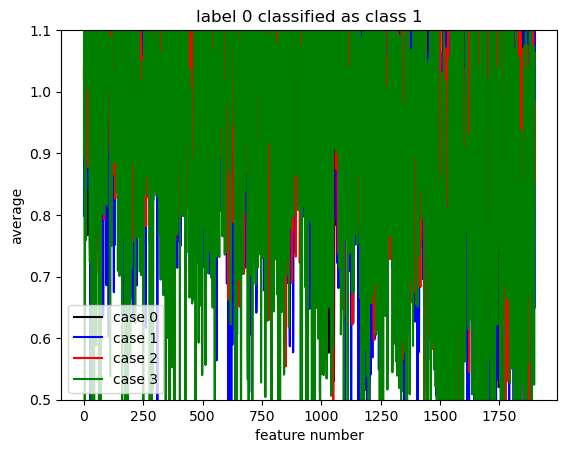

In [69]:
#features of missclassified cases
class0as1=xsel_test[np.where((y_test==0) & (restec3==1)),:]
class0as2=xsel_test[np.where((y_test==0) & (restec3==2)),:]
class1as0=xsel_test[np.where((y_test==1) & (restec3==0)),:]
class1as2=xsel_test[np.where((y_test==1) & (restec3==2)),:]
print(f"shape of selected features {np.shape(class0as1)}")
#probabilities of missclasfied cases
pclass0as1=restep3[np.where((y_test==0) & (restec3==1)),:]
pclass0as2=restep3[np.where((y_test==0) & (restec3==2)),:]
pclass1as0=restep3[np.where((y_test==1) & (restec3==0)),:]
pclass1as2=restep3[np.where((y_test==1) & (restec3==2)),:]
print(f"shape of selected probabilities {np.shape(pclass0as1)}")
plt.plot(resselb[15],class0as1[0,0,:],'-',color='black',label='case 0') 
plt.plot(resselb[15],class0as1[0,1,:],'-',color='blue',label='case 1') 
plt.plot(resselb[15],class0as1[0,2,:],'-',color='red',label='case 2') 
plt.plot(resselb[15],class0as1[0,3,:],'-',color='green',label='case 3') 
plt.title("label 0 classified as class 1")
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")

The feature data is very noisy, therefore we smooth the data for better visualization.

[0.08751786 0.15889414 0.00450805 0.13971511]


Text(0, 0.5, 'average')

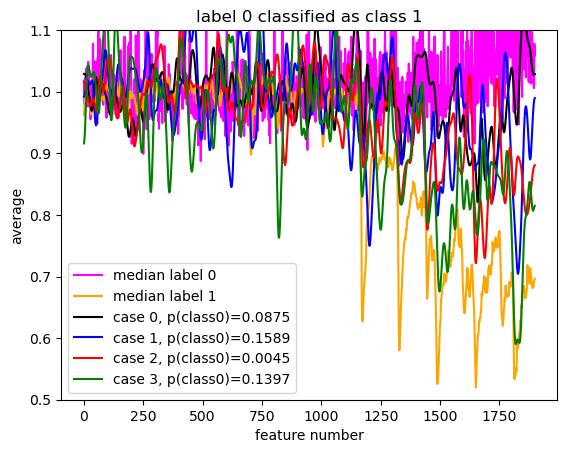

In [70]:
#add probailities in plot
#start
print(pclass0as1[0,0:4,0])
plt.plot(resselb[15],ressel[7],'-',color='magenta',label='median label 0') 
plt.plot(resselb[15],ressel[10],'-',color='orange',label='median label 1') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(class0as1[0,0,:],8),'-',color='black',label=f'case 0, p(class0)={round(pclass0as1[0,0,0],4)}') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(class0as1[0,1,:],8),'-',color='blue',label=f'case 1, p(class0)={round(pclass0as1[0,1,0],4)}') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(class0as1[0,2,:],8),'-',color='red',label=f'case 2, p(class0)={round(pclass0as1[0,2,0],4)}') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(class0as1[0,3,:],8),'-',color='green',label=f'case 3, p(class0)={round(pclass0as1[0,3,0],4)}') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.title("label 0 classified as class 1")
plt.xlabel("feature number")
plt.ylabel("average")

The cases of class 0 classified as case 1 all have many feature below 1 and or thus more similar to class 1. Most have still a arelevant probability of class 0. Case 2 least. In general, because class 0 is the absense of a class they are possible in class 1 in parctice but the data is not good enough to be certain. 

Text(0, 0.5, 'average')

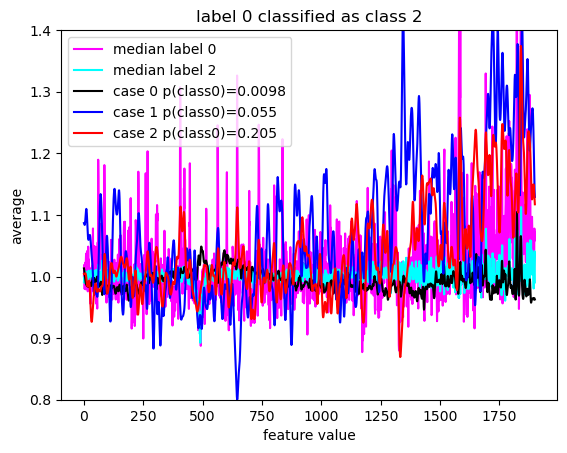

In [71]:
plt.plot(resselb[15],ressel[7],'-',color='magenta',label='median label 0') 
plt.plot(resselb[15],ressel[13],'-',color='cyan',label='median label 2') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(class0as2[0,0,:],2),'-',color='black',label=f'case 0 p(class0)={round(pclass0as2[0,0,0],4)}') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(class0as2[0,1,:],4),'-',color='blue',label=f'case 1 p(class0)={round(pclass0as2[0,1,0],4)}') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(class0as2[0,2,:],4),'-',color='red',label=f'case 2 p(class0)={round(pclass0as2[0,2,0],4)}') 
plt.legend(loc="best")
plt.ylim(0.8,1.4)
plt.title("label 0 classified as class 2")
plt.xlabel("feature value")
plt.ylabel("average")

That is similar for as class 2 classfied sources.

Unsurprisngly, case 0, has the lowest class 0 probability, because it has much lower noise than the other class 0sources. It is still class 0 because it is no sign of another class. 

Text(0, 0.5, 'feature value')

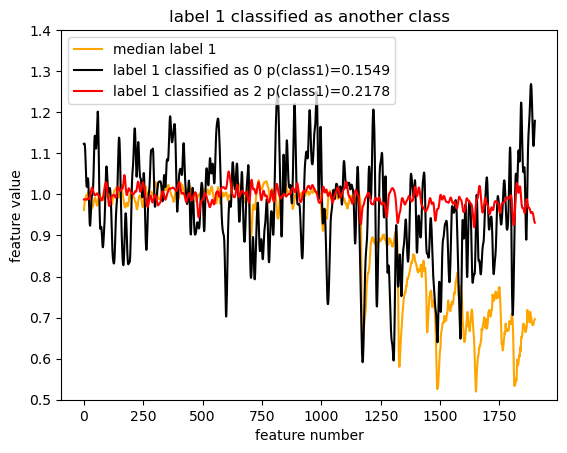

In [76]:
plt.plot(resselb[15],ressel[10],'-',color='orange',label='median label 1') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(class1as0[0,0,:],4),'-',color='black',label=f'label 1 classified as 0 p(class1)={round(pclass1as0[0,0,1],4)}') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(class1as2[0,0,:],4),'-',color='red',label=f'label 1 classified as 2 p(class1)={round(pclass1as2[0,0,1],4)}') 
plt.legend(loc="best")
plt.ylim(0.5,1.4)
#plt.xlim(1100,1400)
plt.title("label 1 classified as another class")
plt.xlabel("feature number")
plt.ylabel("feature value")

The case which classified as class 0 has a rather larger noise and thus it is not surprising that its preferred class is class 0. Similarly, the as class 2 classified source is close to class 2 than most class 1 sources, the spikes around 1140 and 1320 are weaker than of most  class 1 sources. Also the probailities of class 1 is still at least 15% and they are just not sources where the wrong class is certain according to the probability.

In [77]:
#maybe re insert
#for i in range(np.shape(restec3)[0]):
#    if restec3[i]!=y_test[i]:
#        print(f"label {round(y_test[i])} has probabilities {np.round(restep3[i],5)}")

Overall all the missclassified sources are all borderline or of the difficult class 0. Given, the not so large number of difficult class sources overall an improvement is difficult and always in danger of overfitting to the few examples. 

In [ ]:
We are now looking on the coeffiecient of fitted functions. 

In [78]:

print(f"noise coefficients for class (0,1,2) are {lr3.coef_[:,1900]}")


noise coefficients for class (0,1,2) are [ 0.78530793 -0.27183081 -0.51347712]


As it should class 0 has a positive noise coefficents while the other two have coefficients smaller than 0. 
Now the coefficients are shown which do not use feature engeniering. 

Text(0, 0.5, 'coefficient')

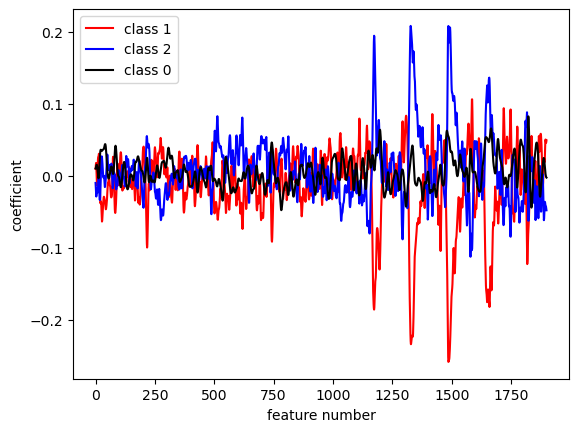

In [79]:
#smoothed for better visualization
plt.plot(resselb[15],sp.ndimage.gaussian_filter(lr3.coef_[1,0:1900],2),'-',color='red',label='class 1') 
plt.plot(resselb[15],sp.ndimage.gaussian_filter(lr3.coef_[2,0:1900],2),'-',color='blue',label='class 2')  
plt.plot(resselb[15],sp.ndimage.gaussian_filter(lr3.coef_[0,0:1900],4),'-',color='black',label='class 0') 
plt.legend(loc="best")
#plt.ylim(0.5,1.4)
plt.xlabel("feature number")
plt.ylabel("coefficient")

The coefficents follow the strongest signal in the median features (see below again) of each class and of the inverse of the other classes.
In case of class 0 it is rather flat for the direct features above, but the coefficient for noise is larger than any other feature overall.  

Text(0, 0.5, 'median feature value')

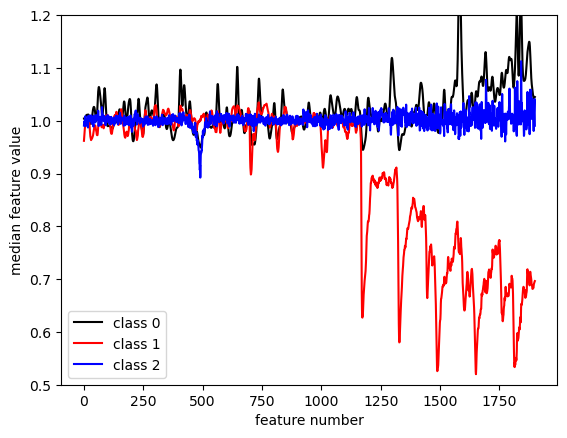

In [92]:
plt.plot(resselb[15],sp.ndimage.gaussian_filter(ressel[7],4),'-',color='black',label='class 0') 
plt.plot(resselb[15],ressel[10],'-',color='red',label='class 1') 
plt.plot(resselb[15],ressel[13],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.2)
plt.xlabel("feature number")
plt.ylabel("median feature value")

In [80]:
#could make data set less homogenous (in feature number -? wavelength, best with adding more examples at the same time
#could use data from me, public or from collaborators, 
#then something more complicated than logistic regression would be needed and more exapmples in rare classes should also 
#make all easier